# Advanced interventions

- Figuring out where an intervention should go, by inspecting a staged model
- How to design your own interventions


In [ ]:
import jax 

from feedbax.xabdeef import point_mass_nn_simple_reaches

seed = 1234
key = jax.random.PRNGKey(seed)
key_init, key_train, key_eval = jax.random.split(key, 3)

context = point_mass_nn_simple_reaches(key=key_init)

task = context.task  # Shorthand, for later

model, train_history = context.train(
    n_batches=1000,
    batch_size=250,
    learning_rate=1e-2,
    log_step=500,
    key=key_train,
)

/home/mll/.miniforge3/envs/fx/lib/python3.11/site-packages/diffrax/adjoint.py:665: UserWarning: As of Equinox 0.10.7, `equinox.filter_custom_vjp.defvjp` is deprecated in favour of `.def_fwd` and `.def_bwd`. This new API supports symbolic zeros, which allow for more efficient autodifferentiation rules. In particular:
- the fwd and bwd functions take an extra `perturbed` argument, which     indicates which primals actually need a gradient. You can use this     to skip computing the gradient for any unperturbed value. (You can     also safely just ignore this if you wish.)
- `None` was previously passed to indicate a symbolic zero gradient for     all objects that weren't inexact arrays, but all inexact arrays     always had an array-valued gradient. Now, `None` may also be passed     to indicate that an inexact array has a symbolic zero gradient.
  _loop_backsolve.defvjp(_loop_backsolve_fwd, _loop_backsolve_bwd)


compile:   0%|          | 0/1 [00:00<?, ?it/s]

Training step compiled.
Validation step compiled.


train batch:   0%|          | 0/1000 [00:00<?, ?it/s]


Training iteration: 0
	training loss: 2.41e+01
	validation loss: 5.39e+00

Training iteration: 500
	training loss: 4.22e-03
	validation loss: 7.78e-04


(<Figure size 1200x600 with 3 Axes>,
 array([<Axes: title={'center': 'Position'}, xlabel='$x$', ylabel='$y$'>,
        <Axes: title={'center': 'Velocity'}, xlabel='$\\dot x$', ylabel='$\\dot y$'>,
        <Axes: title={'center': 'Control force'}, xlabel='$\\mathrm{f}_x$', ylabel='$\\mathrm{f}_y$'>],
       dtype=object))

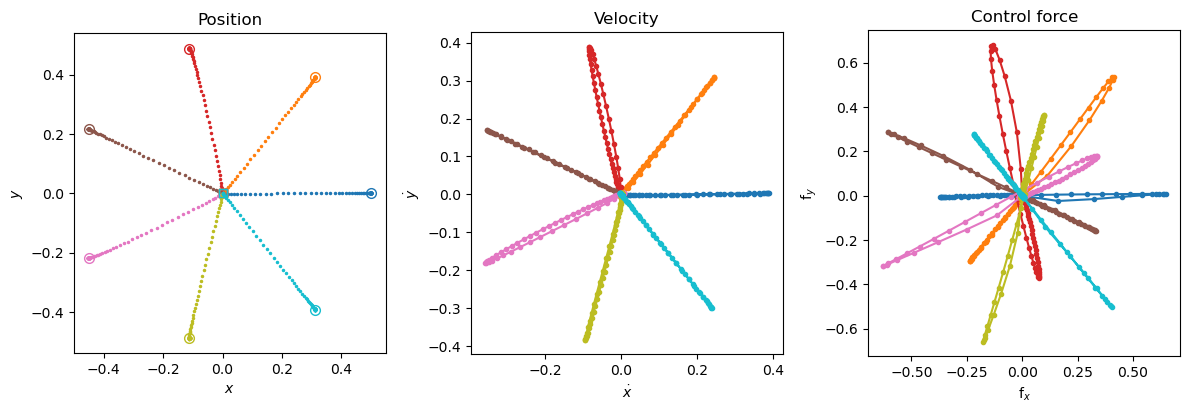

In [ ]:
from feedbax.plot import plot_reach_trajectories

states = task.eval(model, key=key_eval)

plot_reach_trajectories(states, trial_specs=task.validation_trials)

## Time-varying interventions

(Do a little bit of analysis to show why we are constructing the intervenor this way.)

- Examine model and see where feedback channel is
- Examine state and see which part we need to intervene on `state.feedback`
- Examine `model_spec` printout and decide which stage the intervention needs to go before

(How do we know that `model.step.feedback_channels[0]` operates on `state.feedback`? How do we know that `state.feedback.output` is what we need to alter? Should probably enhance the pretty printing of model stages to show the inputs + outputs. Instead of trying to parse them from the lambdas (since they might have arbitrary PyTree structure) we could *evaluate* them and then infer the types of `AbstractState` that are passed or returned, at least.)


In [ ]:
import jax.numpy as jnp


impulse_amp = 10.0
impulse_dim = 0  # 0=x, 1=y
impulse_var = 0  # 0=position, 1=velocity

n_steps = model.n_steps  
t_impulse = int(n_steps * 0.7)

# Make a mask corresponding to the feedback channel to be perturbed
feedback_mask = jnp.zeros((2,)).at[impulse_dim].set(1)

# Make a mask for the time step at which the impulse will be applied
trial_mask = jnp.zeros((n_steps - 1,), bool).at[t_impulse].set(True)

Note that the functions used to generate the intervention parameters can return time series or not

In [ ]:
from feedbax.intervene import ConstantInput

task_fb_impulse, model_fb_impulse = schedule_intervenor(
    task, model, 
    {'add_noise': ConstantInput.with_params(
        out_where=lambda channel_state: channel_state.output,
        amplitude=impulse_amp,
        array_mask=feedback_mask,
        active=lambda trial_spec, key: trial_mask,  # TODO remove the lambda?
    )},
    where=lambda model: model.step.feedback_channels[0],
    default_active=False
)

In [ ]:
plot_reach_trajectories(
    task_fb_impulse.eval(model_fb_impulse, key=key_eval), 
    trial_specs=task.validation_trials,
    straight_guides=True,  # Show dashed lines for "ideal" straight reaches
)

ValueError: Expected tuple, got Traced<ShapedArray(float32[2])>with<DynamicJaxprTrace(level=4/0)>.

## Writing a custom intervenor

Those are just a couple of examples. 
In general, we can write intervenors to modify a model's state

(More analysis, continuing from before.)